<a href="https://colab.research.google.com/github/AnkonGhosh/EfficientCovNet/blob/main/Proposed_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.vision import *

### Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = Path('/content/drive/MyDrive/Large_Data/')

In [ ]:
np.random.seed(41)
data = ImageDataBunch.from_folder(path, train="Train", valid ="Valid",
        ds_tfms=get_transforms(), size=(256,256), bs=32, num_workers=4).normalize()

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  return _solve_func(B,A)[0][:,0]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/free

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'Lung_Opacity', 'No_findings', 'Pneumonia'], 4, 16938, 4227)

In [ ]:
print("Number of examples in training:", len(data.train_ds))
print("Number of examples in validation:", len(data.valid_ds))

Number of examples in training: 16938
Number of examples in validation: 4227


In [ ]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

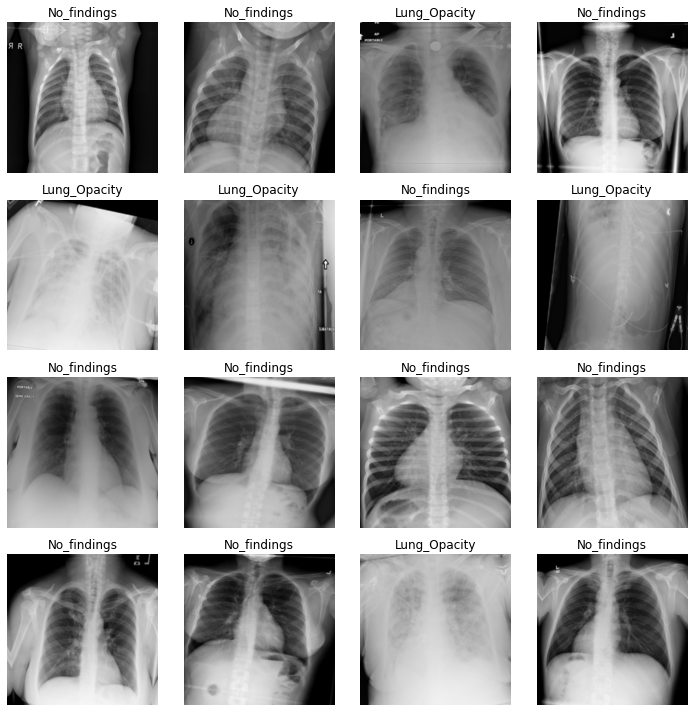

In [ ]:
#Sample images from the dataset
data.show_batch(rows=4, figsize=(10,10))

## Proposed Model


In [ ]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=84134e51a9300d3c82584ea71f5af11ff928c37c5ea4840c8a32a6980c76375a
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet

In [ ]:
class MyEfficientNet(nn.Module):

    def __init__(self):
        super().__init__()

        # EfficientNet
        self.network = EfficientNet.from_pretrained("efficientnet-b0")
        
        # Replace last layer
        self.network._fc = nn.Sequential(nn.Linear(self.network._fc.in_features, 512), 
                                         nn.LeakyReLU(),  
                                         nn.Dropout(0.25),
                                         nn.Linear(512, 128), 
                                         nn.LeakyReLU(), 
                                         nn.Linear(128,4)
                                         )
    
    def forward(self, x):
        out = self.network(x)
        return out

In [ ]:
model = nn.Sequential(
    
    MyEfficientNet()
)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0


In [ ]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [ ]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
ZeroPad2d            [3, 257, 257]        0          False     
______________________________________________________________________
BatchNorm2d          [32, 128, 128]       64         True      
______________________________________________________________________
ZeroPad2d            [32, 130, 130]       0          False     
______________________________________________________________________
BatchNorm2d          [32, 128, 128]       64         True      
______________________________________________________________________
Identity             [32, 1, 1]           0          False     
______________________________________________________________________
Identity             [8, 1, 1]            0          False     
______________________________________________________________________
Identity             [32, 128, 128]       0          False     
___________________________________________________

In [ ]:
learn.fit_one_cycle(20, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.261184,0.318725,0.896144,27:10
1,0.299192,0.329684,0.907026,03:22
2,0.279641,0.314171,0.909392,03:22
3,0.332125,0.567606,0.841968,03:21
4,0.317840,0.231428,0.924769,03:23
5,0.285906,0.543791,0.841968,03:22
6,0.279343,0.404960,0.884552,03:21
7,0.230883,0.295372,0.891176,03:21
8,0.216765,0.284998,0.914597,03:22
9,0.226630,0.342457,0.883842,03:22


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


AttributeError: ignored

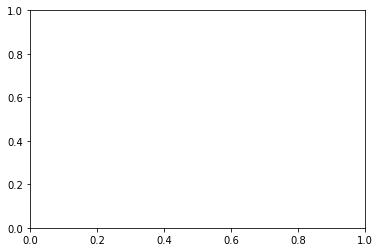

In [ ]:
learn.recorder.plot_losses()

In [ ]:
print("Number of examples in testing:", len(data.valid_ds))

Number of examples in testing: 4227


In [ ]:
probs,targets = learn.get_preds(ds_type=DatasetType.Valid) 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
accuracy(probs,targets)

tensor(0.9612)

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'Lung_Opacity', 'No_findings', 'Pneumonia'], 4, 16938, 4227)

In [ ]:
probs = np.argmax(probs, axis=1)
correct = 0
for idx, pred in enumerate(probs):
    if pred == targets[idx]:
        correct += 1
accuracy = correct / len(probs)
print(len(probs), correct, accuracy)

from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf) 
cm1 = confusion_matrix(targets, probs)
print(cm1)

from sklearn.metrics import classification_report
y_true1 = targets
y_pred1 = probs
target_names = ['Covid-19','Lung_Opacity','No_findings','Pneumonia']
print(classification_report(y_true1, y_pred1, target_names=target_names))

4227 4063 0.9612017979654601
[[ 700    5   13    0]
 [   0 1145   61    0]
 [   3   75 1960    0]
 [   0    0    7  258]]
              precision    recall  f1-score   support

    Covid-19       1.00      0.97      0.99       718
Lung_Opacity       0.93      0.95      0.94      1206
 No_findings       0.96      0.96      0.96      2038
   Pneumonia       1.00      0.97      0.99       265

    accuracy                           0.96      4227
   macro avg       0.97      0.96      0.97      4227
weighted avg       0.96      0.96      0.96      4227



In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


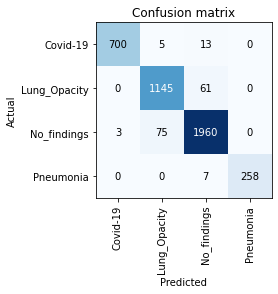

In [ ]:
cm_fig = interp.plot_confusion_matrix(return_fig=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - .5, - .5);